# Watson visual recognition

In this exercise we will train Watson to detect the presence or absense of a specific brand logo in photographs. 

## Getting set up

### Bluemix config and credentials

The first step is to create an instance of [visual recognition](https://console.ng.bluemix.net/catalog/services/visual-recognition/) in your bluemix dashboard and save the associated credentials json to creds.json in the same directory as this IPython notebook.


In [11]:
import json

with open("creds.json") as f:
    creds = json.load(f)['credentials']
 
print ("Username {username} \nGateway: {url}".format(**creds))

Username 3afaa9f3-686e-4894-9aeb-d2be08824d6d 
Gateway: https://gateway.watsonplatform.net/visual-recognition-beta/api


### Libraries
We will mainly be using the default Python libraries in this tutorial but we also want to use [requests](http://docs.python-requests.org/en/latest/) which is a HTTP client framework for python.

The easiest way to install this is to run
<code shell>
    pip install requests
</code>
from your command shell.

Let's test that it is installed, if it isn't you will get an error when you try to run this next code cell.

In [12]:
import requests

### Images 

We need some training data to teach our classifier with. The images should be either .jpg, .png, or .gif with positive examples that depict the object, item or pattern you want to detect and another compressed file with negative examples that are similar to but do NOT show you the entity of interest.

Create zip files called "positive.zip" and "negative.zip" for the respective classifications in the same 

In [13]:

import os

if not os.path.exists("positive.zip"):
    print("No positive examples found")

if not os.path.exists("negative.zip"):
    print("No negative examples found")

## Creating a classifier

In [14]:
API_VERSION = "2015-12-02" #stable version of the visual recognition service

classifiers_url = creds['url'] + "/v2/classifiers?version=" + API_VERSION 

files = {
            'positive_examples' : open('positive.zip','rb'), 
            'negative_examples' : open('negative.zip','rb')
        }

data = { "name" : "my_first_classifier"}

result = requests.post(classifiers_url, 
                       auth=(creds['username'], creds['password']),
                       files=files,
                       data = data
                      )

print(result.json())

{'owner': '0a1141a4-017f-4f62-9c2f-47a67e070b07-us-south', 'classifier_id': 'my_first_classifier_344197487', 'name': 'my_first_classifier', 'created': '2016-01-10T10:53:40.000Z'}


Hopefully our new classifier is now ready. Let's test it. You should create two more zip files full of photos called - positive_test.zip and negative_test.zip. Place them in the same directory as this notebook.

We define a function for testing a zip file full of images using the previously defined classifier.

In [15]:
from IPython.core.display import display, Image

def test_zip(classifier_ids, test_zip):

    global creds

    classifyurl = creds['url'] + "/v2/classify?version=" + API_VERSION 

    files = {
                'image_file' : open(test_zip,'rb'),
            }

    classresult = requests.post(classifyurl, 
                       auth=(creds['username'], creds['password']),
                       files=files,
                       data={"classifier_ids" : ids }
                      )
    
    total = len(classresult.json()['images'])
    positive = []
    negative = []
    for img in classresult.json()['images']:
        
        if 'scores' in img:

            for score in img['scores']:
                if score['name'] == classifier_data['name']:
                    positive.append(img['image'])
                    break
        else:
            #if we got this far the image was negative
            negative.append(img['image'])
    
    #return final scores
    return total, positive, negative

Now we test the positive examples - we hope to see 100% positive classification

Classifier was positive for 6 / 10 positive test images
False negatives:


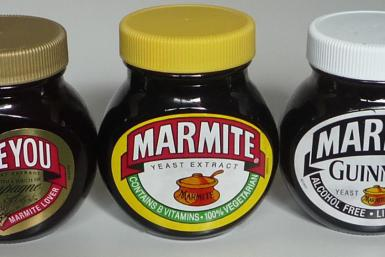

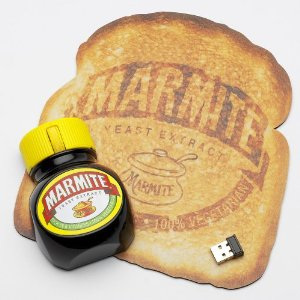

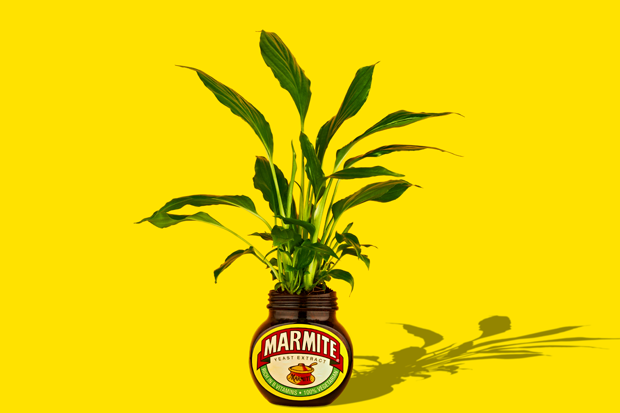

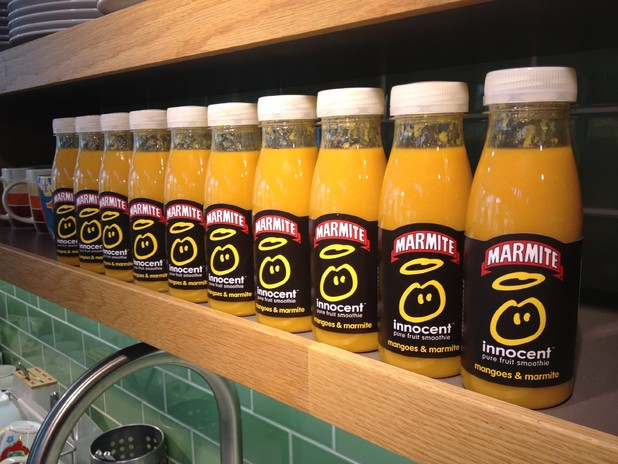

In [16]:
classifier_data = result.json()
ids = json.dumps({'classifier_ids' : [classifier_data['classifier_id']]})

total, pos, neg = test_zip(ids, 'positive_test.zip')

print("Classifier was positive for {} / {} positive test images".format(len(pos), total))

if len(neg) > 0:
    print("False negatives:")
    for img in neg:
        display(Image(filename=img))
        
        

Now we test negative examples - conversely we want to see 100% negative classification.

Classifier was negative for 9 / 10 negative test images
False positives:


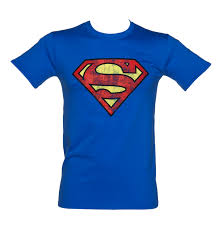

In [8]:
total, pos, neg = test_zip(ids, 'negative_test.zip')

print("Classifier was negative for {} / {} negative test images".format(len(neg), total))

if len(neg) > 0:
    print("False positives:")
    
    for img in pos:
        display(Image(filename=img))

In the case that a large number of images have been incorrectly labelled - we need to rerun this phase with new positive and negative examples to improve training.

## Managing classifiers

We may want to see what classifiers we have generated and potentially delete ones that are not effectively trained.

### Listing existing classifiers
We can do a GET request to /v2/classifiers to get a list of classifiers. This will return all of your instances but also the built in instances provided by IBM. Here we use a regular expression to filter out the IBM ones that have simple ID strings like 'Brown' and 'Earthquake' from the custom ones that have an ID string ending with an underscore and a timestamp.

In [ ]:
import re

result = requests.get(classifiers_url,  auth=(creds['username'], creds['password']))

for classifier in result.json()['classifiers']:
    
    if re.match(".+_[0-9]+$",classifier['classifier_id']):
        print (classifier)
        


### Deleting a classifier

Assuming there is a classifier we want to delete from above, we just make an HTTP DELETE to the classifiers/{classifier_id} endpoint.

In [ ]:
CLASSIFIER_ID = 'my_first_classifier_1536936254'
classifier_url = creds['url'] + "/v2/classifiers/{}?version={}".format(CLASSIFIER_ID,API_VERSION )

result = requests.delete(classifier_url,  auth=(creds['username'], creds['password']))

if result.status_code == 200:
    print("Classifier was deleted")

## Making multiple classifications

What happens if you want to determine whether an image contains a number of concepts/classifications or whether it belongs to one of a number of categories.

The above workflow can be applied to an image with multiple classifiers at the same time.

**nb: The API does not distinguish between **

In [ ]:

classifyurl = creds['url'] + "/v2/classify?version=" + API_VERSION 

files = {
            'image_file' : open('test2.jpg','rb'),
        }

ids = json.dumps({'classifier_ids' : ['Cat', 'Dog']})

classresult = requests.post(classifyurl, 
                   auth=(creds['username'], creds['password']),
                   files=files,
                   data={'classifier_ids' : ids}
                  )

print (classresult.json())